In [52]:
import time
import os
import torch
from torchvision import transforms
import random
import numpy as np
import yaml
from PIL import Image
from experiment import VAEXperiment
from models import *


import gymnasium as gym
from gymnasium import ObservationWrapper
from gymnasium.wrappers import PixelObservationWrapper, FrameStack
from gymnasium.spaces import Box, Discrete

from stable_baselines3 import SAC, PPO, A2C

In [53]:
from gymnasium import ObservationWrapper
from gymnasium.wrappers import PixelObservationWrapper, FrameStack
from gymnasium.spaces import Box, Discrete
import numpy as np
import yaml
from experiment import VAEXperiment
from models import *
import torch
from torchvision import transforms
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

#ideas
#maybe use wrapper to catch and save frames during RL model learning
#alternative is to use the model afterwards to generate frames during a test run
#
#??return mu, std or sample or just mu??
#
class VAE_ENC(ObservationWrapper):
    def __init__(self, env, vae, latent_dim,
                 mean=0,std=0.1,
                 size=(64,64)):
        super().__init__(env)
        #new obs space with std
        #self.observation_space = Box(shape=(2, latent_dim), low=-np.inf, high=np.inf)
        #just mean
        self.observation_space = Box(shape=(latent_dim,), low=-np.inf, high=np.inf)
        
        self.vae = vae
        #transforms
        self.mean = mean
        self.std = std
        self.size = size
        
        
        
    def observation(self, obs):
        #get frame
        #print(obs)
        frame = obs['pixels']#.to('cuda')
        #transform for VAE
        val_transforms = transforms.Compose([transforms.ToTensor(),
        #transforms.RandomHorizontalFlip(),
        AddGaussianNoise(self.mean, self.std),
        transforms.Resize(self.size),
        #transforms.Grayscale(),
        #transforms.Normalize(self.mean, self.std),
        ])
        frame = val_transforms(frame) #(c,h,w)
        frame = torch.unsqueeze(frame, 0)#.to(self.device) #make it (1,c,h,w)
        enc = self.vae.encode(frame)    
        enc = np.array([tensor.detach().cpu().numpy() for tensor in enc])
        #with std
        #enc = np.array([enc[0][0], enc[1][0]]) ## mu, std #  give only mu?
        #just mean
        enc = np.array(enc[0][0])
        return enc
    
def get_vae(version='version_0',log_directory='Code/VAE_RL/logs/BCE_sum_VAE/MSSIMVAE/'):

    model_path=log_directory+'/'+version+'/hparams.yaml'
    ckpt_path=log_directory+'/'+version+'/checkpoints/last.ckpt'

    config = yaml.safe_load(open(model_path))
    model = vae_models[config['model_params']['name']](**config['model_params'])
    ckpt = torch.load(ckpt_path)
    experiment = VAEXperiment(model, config['exp_params'])
    experiment.load_state_dict(ckpt['state_dict'])      
    vae = experiment.model
    return vae

In [112]:
vae_version ='8'
vae_resets = '0'
rl_resets = '1'

path = 'logs/MountainCar/BCE_test1_VAE_2/MSSIMVAE'
vae = get_vae(version='version_'+vae_version, log_directory= path )

AGENT and ENv

In [113]:
env = gym.make("MountainCarContinuous-v0",
                render_mode ='rgb_array')
seed = 42
env.reset(seed=seed)
env = PixelObservationWrapper(env)
env = VAE_ENC(env, vae, 2)
env = FrameStack(env, num_stack=2)
env = Monitor(env)

agent= A2C.load('RLmodels/MountainCarContinuous-v0/Double_loop/end_of_loop_save/Test1_A2C_vae_l2_v'+vae_version+'__'+vae_resets+'vae_resets__'+rl_resets+'rl_resets__.zip', env)

In [114]:
num_of_episodes=2
#i=0
all_frames = []
all_rewards = []
all_latent_trajectories = []
for episode in range(num_of_episodes):
    observation, info = env.reset()
    cum_reward = 0
    done = False
    latent_trajectory = []
    frames = []
    while not done: 
        action, _states = agent.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        cum_reward += reward
        latent_trajectory.append(np.array(observation[0]))
        #state, reward, terminated, truncated, info = env.step(action)
        #print(terminated, truncated)
        if terminated:
            done = True
        if truncated:
            done = True
        current_frame = env.render()
        frames.append(np.array(current_frame))
    all_rewards.append(cum_reward)
    all_frames.append(np.array(frames))
    all_latent_trajectories.append(np.array(latent_trajectory))
        #i+=1
        #im = Image.fromarray(np.array(current_frame))
        #im.save(save_path+'/'+data_name+'_'+str(i)+'.jpeg')
        #im.save('Data/lunar-lander/data_comb_third_vae/'+data_name+'_'+str(i)+'.jpeg')
print(all_rewards)

[85.46327337157007, 83.0816419495178]


In [115]:
print(all_rewards)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA

def plot_2D_trajectories_with_colors(trajectories):
    fig, ax = plt.subplots()

    colormaps = ['Greens', 'Purples', 'Blues', 'Oranges', 'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'] 


    i = 0
    for trajectory in trajectories:
        #print(trajectory)
        x = trajectory[:,0]
        y = trajectory[:,1]

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)

        start_index = int(num_frames * (2 / 3))
        trajectory_colors[:start_index] = trajectory_colors[start_index]

        scatter = ax.scatter(x, y, c=trajectory_colors, alpha=1, marker='o')
        i+=1
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Plot of Trajectories with Color Progression')

    plt.show()
    
def plot_1D_trajectories_with_colors(trajectories):
    fig, ax = plt.subplots()

    colormaps = ['Greens', 'Purples', 'Blues', 'Oranges', 'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'] 


    i = 0
    for trajectory in trajectories:
        #print(trajectory)           
        y = trajectory[:,0]
        x = np.arrange(len(y))
        
        
        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)

        start_index = int(num_frames * (2 / 3))
        trajectory_colors[:start_index] = trajectory_colors[start_index]

        scatter = ax.scatter(x, y, c=trajectory_colors, alpha=1, marker='o')
        i+=1
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Plot of Trajectories with Color Progression')

    plt.show()

[85.46327337157007, 83.0816419495178]


/tmp/ipykernel_20312/51562977.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormaps[colormap_index])


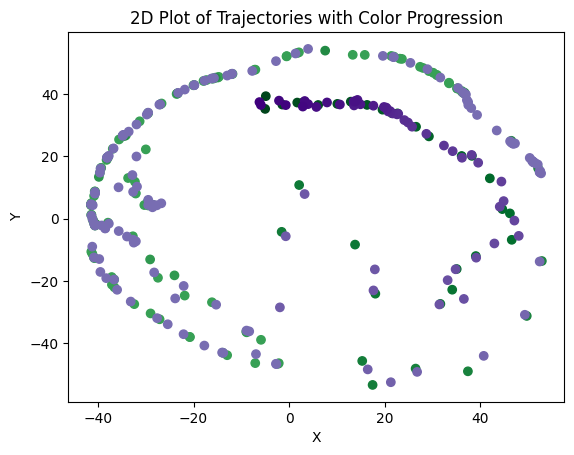

In [116]:
plot_1D_trajectories_with_colors(all_latent_trajectories)

In [5]:
num_of_episodes = 2  # Replace 'n' with the desired number of trajectories
frames = []
all_rewards =[]
for episode in range(num_of_episodes):
    observation, info = env.reset()
    done = False
    trajectory = []  # Initialize trajectory list for the current episode
    cum_reward = 0
    while not done:
        action, _states = agent.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        cum_reward += reward
        if terminated or truncated:
            done = True
        
        current_frame = env.render()
        trajectory.append(current_frame)  # Add current frame to the trajectory
    all_rewards.append(cum_reward)
    frames.append(np.array(trajectory))  # Add the trajectory to the list of frames

# Pass the 'frames' list to the plot_multiple_trajectories function


In [ ]:
tensor_frames = [torch.from_numpy(item).float() for item in frames]

In [7]:
latent_vectors =[]
val_transforms = transforms.Compose([transforms.ToTensor(),
#transforms.RandomHorizontalFlip(),
AddGaussianNoise(0, 0.1),
transforms.Resize((64,64)),
#transforms.Grayscale(),
#transforms.Normalize(self.mean, self.std),
])
trajectories = []
for trajectory in frames:
    latent_vectors = []
    for frame in trajectory:
        frame = val_transforms(frame) #(c,h,w)
        frame = torch.unsqueeze(frame, 0)#.to(self.device) #make it (1,c,h,w)
        enc = vae.encode(frame)
        enc = np.array([tensor.detach().cpu().numpy() for tensor in enc])
        #with std
        #enc = np.array([enc[0][0], enc[1][0]]) ## mu, std #  give only mu?
        #just mean
        enc = np.array([enc[0][0][0], enc[1][0][0]])
        latent_vectors.append(enc)
    trajectories.append(np.array(latent_vectors))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA

def plot_trajectories_with_colors(trajectories):
    fig, ax = plt.subplots()

    colormaps = ['Greens', 'Purples', 'Blues', 'Oranges', 'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']


    i = 0
    for trajectory in trajectories:
        
        x = trajectory[:,0]
        y = trajectory[:,1]

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)

        start_index = int(num_frames * (2 / 3))
        trajectory_colors[:start_index] = trajectory_colors[start_index]

        scatter = ax.scatter(x, y, c=trajectory_colors, alpha=1, marker='o')
        i+=1
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('2D Plot of Trajectories with Color Progression')

    plt.show()
    
    
    
num_of_episodes = 2  # Replace 'n' with the desired number of trajectories
frames = []

for episode in range(num_of_episodes):
    observation, info = env.reset()
    done = False
    trajectory = []  # Initialize trajectory list for the current episode
    
    while not done:
        action, _states = agent.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            done = True
        
        current_frame = env.render()
        trajectory.append(current_frame)  # Add current frame to the trajectory
    
    frames.append(np.array(trajectory))  # Add the trajectory to the list of frames

# Pass the 'frames' list to the plot_multiple_trajectories function
latent_vectors =[]
val_transforms = transforms.Compose([transforms.ToTensor(),
#transforms.RandomHorizontalFlip(),
AddGaussianNoise(0, 0.1),
transforms.Resize((64,64)),
#transforms.Grayscale(),
#transforms.Normalize(self.mean, self.std),
])
trajectories = []
for trajectory in frames:
    latent_vectors = []
    for frame in trajectory:
        frame = val_transforms(frame) #(c,h,w)
        frame = torch.unsqueeze(frame, 0)#.to(self.device) #make it (1,c,h,w)
        enc = vae.encode(frame)
        enc = np.array([tensor.detach().cpu().numpy() for tensor in enc])
        #with std
        #enc = np.array([enc[0][0], enc[1][0]]) ## mu, std #  give only mu?
        #just mean
        enc = np.array([enc[0][0][0], enc[1][0][0]])
        latent_vectors.append(enc)
    trajectories.append(np.array(latent_vectors))

plot_trajectories_with_colors(trajectories)

In [10]:
import pacmap
import matplotlib.pyplot as plt
embedding = pacmap.PaCMAP(n_components=3, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
X_transformed = embedding.fit_transform(latent_vectors, init="pca")
# visualize the embedding
#fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral",  s=0.6)

In [57]:
from sklearn.manifold import TSNE
frames_tsne =  TSNE(n_components=3).fit_transform(np.array(latent_vectors))

/tmp/ipykernel_4673/2523424982.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormaps[colormap_index])  # Select a colormap for each trajectory
/tmp/ipykernel_4673/2523424982.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormaps[colormap_index])  # Select a colormap for each trajectory
/tmp/ipykernel_4673/2523424982.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormaps[colormap_index])  # Select

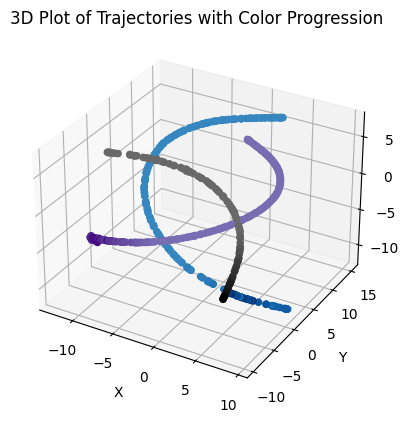

In [19]:
import pacmap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import torch
from torchvision import transforms
import matplotlib.cm as cm

def plot_trajectories_with_colors(trajectories):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

    for i, trajectory in enumerate(trajectories):
        latent_vectors = []
        val_transforms = transforms.Compose([
            transforms.ToTensor(),
            #transforms.RandomHorizontalFlip(),
            AddGaussianNoise(0, 0.1),
            transforms.Resize((64, 64)),
            #transforms.Grayscale(),
            #transforms.Normalize(self.mean, self.std),
        ])

        for frame in trajectory:
            frame = val_transforms(frame)  # (c,h,w)
            frame = torch.unsqueeze(frame, 0)  # Make it (1,c,h,w)
            enc = vae.encode(frame)
            enc = np.array([tensor.detach().cpu().numpy() for tensor in enc])
            # With std
            # enc = np.array([enc[0][0], enc[1][0]])  ## mu, std #  give only mu?
            # Just mean
            enc = np.array(enc[0][0])
            latent_vectors.append(enc)

        # Apply PaCMAP dimensionality reduction
        embedding = pacmap.PaCMAP(n_components=3, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
        reduced_trajectory = embedding.fit_transform(latent_vectors, init="pca")

        x = reduced_trajectory[:, 0]
        y = reduced_trajectory[:, 1]
        z = reduced_trajectory[:, 2]

        num_frames = len(trajectory)
        color_values = np.linspace(0.5, 1, num_frames)

        colormap_index = i % len(colormaps)
        cmap = cm.get_cmap(colormaps[colormap_index])  # Select a colormap for each trajectory

        normalized_color_values = (color_values - np.min(color_values)) / (np.max(color_values) - np.min(color_values))
        trajectory_colors = cmap(normalized_color_values)

        start_index = int(num_frames * (2 / 3))  # Start index for the later three thirds of the colormap
        trajectory_colors[:start_index] = trajectory_colors[start_index]  # Set the color of the initial points
        
        scatter = ax.scatter3D(x, y, z, c=trajectory_colors, alpha=1, marker='o')


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Plot of Trajectories with Color Progression')

    plt.show()
    



num_of_episodes = 3
trajectories = []
for episode in range(num_of_episodes):
    observation, info = env.reset()
    done = False
    trajectory = []

    while not done:
        action, _states = agent.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        current_frame = env.render()
        trajectory.append(current_frame)

        if terminated or truncated:
            trajectories.append(np.array(trajectory))
            trajectory = []

        if terminated:
            done = True
        if truncated:
            done = True

plot_trajectories_with_colors(trajectories)

In [36]:
len(trajectories[0][:,0])

268

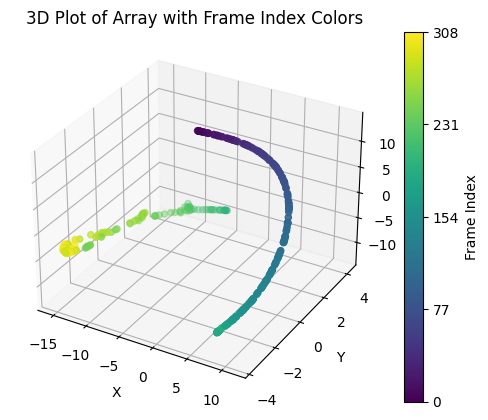

In [12]:

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sns
from mpl_toolkits import mplot3d
def plot_3d_array_with_frame_colors(array):
    x = array[:, 0]  # Extract the first dimension (x-coordinate)
    y = array[:, 1]  # Extract the second dimension (y-coordinate)
    z = array[:, 2]  # Extract the third dimension (z-coordinate)

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    # Create a colormap based on frame indices
    num_frames = len(array)
    colormap = plt.get_cmap('viridis')
    normalized_indices = np.linspace(0, 1, num_frames)
    colors = [colormap(ind) for ind in normalized_indices]

    # Plot the points with colors based on frame indices
    scatter = ax.scatter3D(x, y, z, c=normalized_indices, cmap=colormap)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Plot of Array with Frame Index Colors')

    # Create a colorbar to show the frame indices
    sm = ScalarMappable(cmap=colormap)
    sm.set_array([])
    num_ticks = 5  # Set the desired number of ticks on the colorbar
    tick_positions = np.linspace(0, 1, num_ticks)
    cbar = plt.colorbar(sm, ax=ax, ticks=tick_positions, orientation='vertical')
    cbar.set_label('Frame Index')
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([int(ind * (num_frames - 1)) for ind in tick_positions])

    plt.show()

# Example usage
my_array = X_transformed  # Replace with your array
plot_3d_array_with_frame_colors(my_array)

/tmp/ipykernel_899/574199115.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('rainbow')


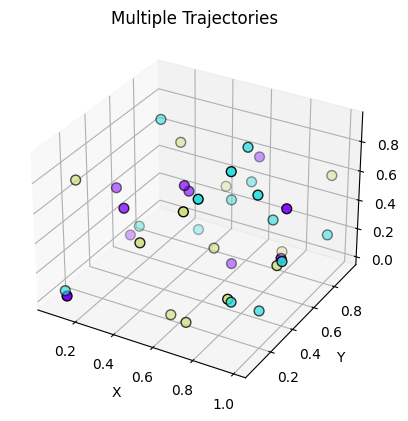

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.cm import get_cmap
import numpy as np

def plot_multiple_trajectories(trajectories):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    num_trajectories = len(trajectories)
    colormap = get_cmap('rainbow')

    for i, trajectory in enumerate(trajectories):
        x = trajectory[:, 0]
        y = trajectory[:, 1]
        z = trajectory[:, 2]

        color = colormap(i / num_trajectories)
        alpha = np.linspace(0.3, 1, len(trajectory))
        size = 50#np.linspace(10, 80, len(trajectory))

        ax.scatter3D(x, y, z, c=[color], alpha=alpha, s=size, edgecolors='k')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Multiple Trajectories')

    plt.show()

# Example usage
trajectory1 = np.random.rand(10, 3)  # Replace with your first trajectory array
trajectory2 = np.random.rand(15, 3)  # Replace with your second trajectory array
trajectory3 = np.random.rand(12, 3)  # Replace with your third trajectory array

trajectories = [trajectory1, trajectory2, trajectory3]

plot_multiple_trajectories(trajectories)

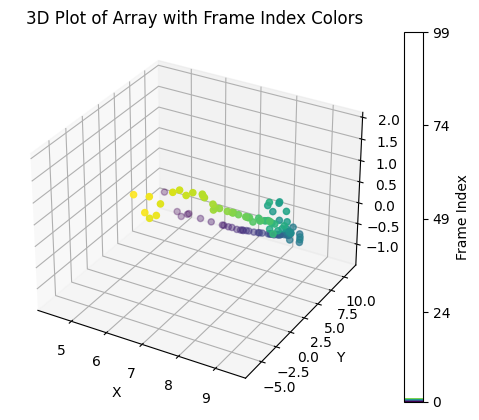

In [51]:
plot_3d_array_with_frame_colors(frames_tsne[100:200])

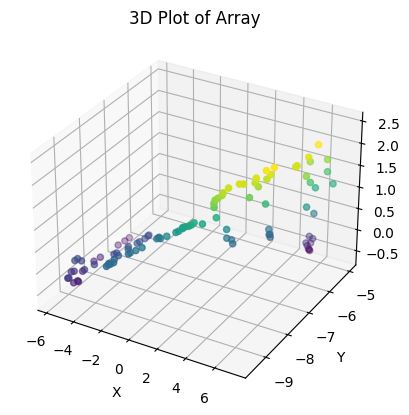

In [32]:
plot_3d_array(frames_tsne[200:300])

In [59]:
from PIL import Image, ImageDraw, ImageFont

def create_gif_with_frame_numbers(frames, filename, duration=100):
    images = []
    
    for i, frame in enumerate(frames):
        # Create a PIL Image object from the frame
        image = Image.fromarray(frame)
        
        # Add frame number annotation to the image
        draw = ImageDraw.Draw(image)
        font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/Ubuntu-B.ttf", 12)  # Replace with the desired font and size
        draw.text((10, 10), f"Frame {i}", fill="white", font=font)
        
        images.append(image)
    
    # Save the list of PIL Images as a GIF
    images[0].save(filename, save_all=True, append_images=images[1:], duration=duration, loop=0)

# Example usage
my_frames = frames  # Replace with your array of frames

# Call the function to create the GIF with frame numbers
create_gif_with_frame_numbers(my_frames, 'output.gif', duration=100)